# PageRank Exercises

Uses the undirected Zachary Karate Club graph (insert reference).

In [1]:
import time
import pygraphblas as grb
from pygraphblas.gviz import *
from pathlib import Path

In [2]:
# Build the Karate Club Graph
NUM_NODES = 34

iA = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
      1,1,1,1,1,1,1,1,1,
      2,2,2,2,2,2,2,2,2,2,
      3,3,3,3,3,3,
      4,4,4,
      5,5,5,5,
      6,6,6,6,
      7,7,7,7,
      8,8,8,8,8,
      9,9,
      10,10,10,
      11,
      12,12,
      13,13,13,13,13,
      14,14,
      15,15,
      16,16,
      17,17,
      18,18,
      19,19,19,
      20,20,
      21,21,
      22,22,
      23,23,23,23,23,
      24,24,24,
      25,25,25,
      26,26,
      27,27,27,27,
      28,28,28,
      29,29,29,29,
      30,30,30,30,
      31,31,31,31,31,31,
      32,32,32,32,32,32,32,32,32,32,32,32,
      33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33]

jA = [1,2,3,4,5,6,7,8,10,11,12,13,17,19,21,31,
      0,2,3,7,13,17,19,21,30,
      0,1,3,7,8,9,13,27,28,32,
      0,1,2,7,12,13,
      0,6,10,
      0,6,10,16,
      0,4,5,16,
      0,1,2,3,
      0,2,30,32,33,
      2,33,
      0,4,5,
      0,
      0,3,
      0,1,2,3,33,
      32,33,
      32,33,
      5,6,
      0,1,
      32,33,
      0,1,33,
      32,33,
      0,1,
      32,33,
      25,27,29,32,33,
      25,27,31,
      23,24,31,
      29,33,
      2,23,24,33,
      2,31,33,
      23,26,32,33,
      1,8,32,33,
      0,24,25,28,32,33,
      2,8,14,15,18,20,22,23,29,30,31,33,
      8,9,13,14,15,18,19,20,22,23,26,27,28,29,30,31,32]
        
def BuildMatrix():
    graph = grb.Matrix.from_lists(iA, jA, [True]*len(iA), nrows=NUM_NODES, ncols=NUM_NODES, typ=grb.types.BOOL)
    return graph
    
style=[{'selector': 'node',
               'style': {'background-color': 'blue',
                         'label': 'data(id)',
                         'width': 2,
                         'height': 2,
                         'shape': 'circle',
                         'color': '#000000',
                         'font-weight': 400,
                         'text-halign': 'right', 
                         'text-valign': 'bottom',
                         'font-size': 4}},
              {'selector': 'edge',
               'style': {'width': 0.2,
                         'opacity': 1,
                         #'label': 'data(id)',
                         'line-color': 'green',
                         'font-size': 4}}]

G = BuildMatrix()
draw_cy(G, visual_style=style)
#draw(G)

Cytoscape(data={'directed': True, 'elements': {'nodes': [{'data': {'id': '0'}}, {'data': {'id': '1'}}, {'data'…

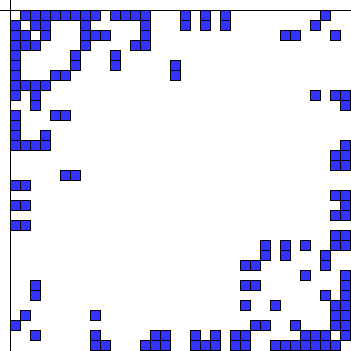

In [15]:
draw_matrix(G, labels=False, scale=10, font_path=Path('.')) #, cmap="Blues")

In [3]:
def pagerank(A, damping = 0.85, tol = 1e-4, itermax = 100):
    n = A.nrows
    d = grb.Vector.sparse(grb.types.FP32, n)
    A.reduce_vector(out=d, mon=grb.types.FP32.PLUS_MONOID)
    d.assign_scalar(damping, accum=grb.types.FP32.DIV)
    r = grb.Vector.sparse(grb.types.FP32, n)
    t = grb.Vector.sparse(grb.types.FP32, n)
    r[:] = 1.0 / n
    for i in range(itermax):
        t[:] = r[:]
        w = t / d
        r[:] = (1 - damping) / n
        w.vxm(A, out=r, accum=grb.types.FP32.PLUS, semiring=grb.types.FP32.PLUS_TIMES)
        t = t - r
        t.apply(grb.types.FP32.ABS, out=t)
        rdiff = t.reduce_float(grb.types.FP32.PLUS_MONOID)
        if rdiff <= tol:
            break
    return r

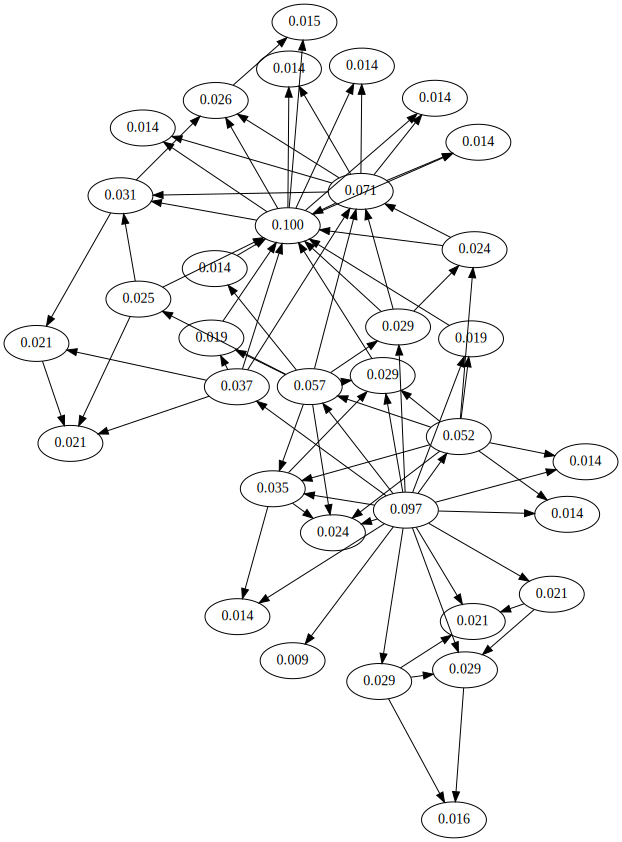

In [4]:
pr = pagerank(G)
draw_graph(G, label_vector=pr, show_weight=False, label_width=5, graph_attr=dict(layout='neato'))

In [5]:
# Timing comparison on a larger graph
pathname = './Data/hpec_coauthors.mtx'

with open(pathname, 'r') as f:
    t0 = time.time()
    M = grb.Matrix.from_mm(f, grb.INT64)
    t1 = time.time()
    print("*** Load graph: Elapsed time: %s sec. (nodes, edges) = (%ld, %ld) %ld" % ((t1 - t0), M.nrows, M.nvals, M.ncols))
    
    # It is weighted so we need to make it unweighted
    Mpattern = M.pattern(typ = grb.INT64)
    print("*** Pattern graph (nodes, edges) = (%ld, %ld) %ld" % (M.nrows, M.nvals, M.ncols))
        
    
    t0 = time.time()
    num_triangles = triangleCount_v1(Mpattern)
    t1 = time.time()
    print("V1  elapsed time: %s sec. Number of triangles = %ld" % ((t1-t0), num_triangles))

    t0 = time.time()
    num_triangles = triangleCount_v2b(Mpattern)
    t1 = time.time()
    print("V2b elapsed time: %s sec. Number of triangles = %ld" % ((t1-t0), num_triangles))
        
    t0 = time.time()
    Lsorted = sortDescending_extractLower(Mpattern)
    t1 = time.time()
    print("V3  sorting time: %s sec." % (t1-t0))
    t0 = time.time()
    C = Lsorted.mxm(Lsorted, semiring=grb.types.UINT64.PLUS_TIMES, mask=Lsorted)
    num_triangles =C.reduce_int(grb.types.UINT64.PLUS_MONOID)
    t1 = time.time()
    print("V3  elapsed time: %s sec. Number of triangles = %ld" % ((t1-t0), num_triangles))


*** Load graph: Elapsed time: 0.03705906867980957 sec. (nodes, edges) = (1747, 10072) 1747
*** Pattern graph (nodes, edges) = (1747, 10072) 1747


NameError: name 'triangleCount_v1' is not defined